# Retrieval-Augmented Generation (RAG)
 RAG is an AI method that first retrieves information from a database and then generates an answer using that info.

## Installations Library


In [82]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph



## API keys and environment variables.

In [83]:
import getpass
import os
from google.colab import userdata

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] =  userdata.get('LANGSMITH_API_KEY')
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

## Chat Model

In [10]:
!pip install -qU "langchain[google-genai]"

In [84]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

## embeddings model

In [85]:
!pip install -qU langchain-huggingface

In [86]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

## store model

In [87]:

!pip uninstall -y opentelemetry-sdk opentelemetry-exporter-otlp-proto-grpc opentelemetry-util opentelemetry-instrumentation chromadb langchain_chroma

!pip install -U "chromadb>=0.4.24" "opentelemetry-sdk==1.33.0" "opentelemetry-api==1.33.0" "opentelemetry-exporter-otlp-proto-grpc==1.33.0"

!pip install -U langchain langchain-chroma


Found existing installation: opentelemetry-sdk 1.33.0
Uninstalling opentelemetry-sdk-1.33.0:
  Successfully uninstalled opentelemetry-sdk-1.33.0
Found existing installation: opentelemetry-exporter-otlp-proto-grpc 1.33.0
Uninstalling opentelemetry-exporter-otlp-proto-grpc-1.33.0:
  Successfully uninstalled opentelemetry-exporter-otlp-proto-grpc-1.33.0
Found existing installation: opentelemetry-instrumentation 0.54b0
Uninstalling opentelemetry-instrumentation-0.54b0:
  Successfully uninstalled opentelemetry-instrumentation-0.54b0
Found existing installation: chromadb 1.0.9
Uninstalling chromadb-1.0.9:
  Successfully uninstalled chromadb-1.0.9
Found existing installation: langchain-chroma 0.2.4
Uninstalling langchain-chroma-0.2.4:
  Successfully uninstalled langchain-chroma-0.2.4
  Using cached chromadb-1.0.9-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.9 kB)
  Using cached opentelemetry_sdk-1.33.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached opentelemetry_exp

In [88]:
from langchain_chroma import Chroma
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db"
)

### Define a prompt for question answering.

In [89]:
# Define prompt for question-answering
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()
# Example question (before the document)
question = "Who became the 50th Vice President of the United States in 2025?"

# Without Retrieval (empty context)
filled prompt = prompt.format(context="", question=question)
response = model.invoke(filled prompt)
print("\n Answer without context:\n", response.content)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(



 Answer without context:
 I don't know.


## Loading documents.

In [90]:
!pip install text_splitter



ERROR: Could not find a version that satisfies the requirement text_splitter (from versions: none)
ERROR: No matching distribution found for text_splitter


In [91]:
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
import chromadb
from langchain.vectorstores import Chroma
# 1. Load webpage
loader = WebBaseLoader(web_paths=["https://en.wikipedia.org/wiki/2025_in_the_United_States"])
docs = loader.load()

# 2. Split into ≥ 50 chunks
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Chunks of max 1000 characters
    chunk_overlap=200,  # 200 characters overlap between chunks
    separators=["\n\n", "\n", ".", " ", ""]
)
# Split chunks
all_splits = splitter.split_documents(docs)

# 3. Initialize HuggingFace embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# 4. Initialize vector store with ChromaDB
client = chromadb.Client()

# Initialize ChromaDB database, this could also be the name of your specific collection
vector_store = Chroma.from_documents(documents=all_splits, embedding=embeddings, client=client, collection_name="2025_in_the_US")

# 5. Add documents to the vector store
vector_store.add_documents(all_splits)

# Output the number of chunks
print(f"Number of chunks: {len(all_splits)}")


Number of chunks: 202


## Retrieval and Generation

In [92]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [93]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [94]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [95]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}

## Control flow

In [96]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

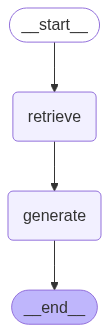

In [97]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## test

In [98]:
result = graph.invoke({"question": "Who became the new President of the USA on January 20, 2025?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'title': '2025 in the United States - Wikipedia', 'source': 'https://en.wikipedia.org/wiki/2025_in_the_United_States', 'language': 'en'}, page_content='^ Balk, Tim (November 6, 2024). "When Will Donald Trump Take Office?". The New York Times. Retrieved November 6, 2024.\n\n^ Reilly, Ryan J. (January 20, 2025). "Trump pardons roughly 1,500 criminal defendants charged in the Jan. 6 Capitol attack". NBC News. NBCUniversal Media, LLC. Retrieved January 20, 2025.\n\n^ Daniels, Cheyanne M. (November 13, 2024). "Sharpton to hold MLK rally on same day as Trump inauguration". The Hill.\n\n^ "National Action Network announces 2025 Inauguration Day rally". November 25, 2024.\n\n^ "Restoring Names That Honor American Greatness". White House. January 2025.\n\n^ Kelly, Laura (January 20, 2025). "Rubio unanimously confirmed as secretary of State, becoming Trump\'s first Cabinet official". thehill.com. Retrieved January 27, 2025.\n\n^ Satter, Raphael; Reid, Tim; Singh, Kan

 ## langGraph workflow

In [99]:
for step in graph.stream(
    {"question": "Who became the new President of the USA on January 20, 2025?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(metadata={'title': '2025 in the United States - Wikipedia', 'language': 'en', 'source': 'https://en.wikipedia.org/wiki/2025_in_the_United_States'}, page_content='^ Balk, Tim (November 6, 2024). "When Will Donald Trump Take Office?". The New York Times. Retrieved November 6, 2024.\n\n^ Reilly, Ryan J. (January 20, 2025). "Trump pardons roughly 1,500 criminal defendants charged in the Jan. 6 Capitol attack". NBC News. NBCUniversal Media, LLC. Retrieved January 20, 2025.\n\n^ Daniels, Cheyanne M. (November 13, 2024). "Sharpton to hold MLK rally on same day as Trump inauguration". The Hill.\n\n^ "National Action Network announces 2025 Inauguration Day rally". November 25, 2024.\n\n^ "Restoring Names That Honor American Greatness". White House. January 2025.\n\n^ Kelly, Laura (January 20, 2025). "Rubio unanimously confirmed as secretary of State, becoming Trump\'s first Cabinet official". thehill.com. Retrieved January 27, 2025.\n\n^ Satter, Raphael; Reid,

## Adjust the prompt (5 attempt)

In [100]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [101]:
for step in graph.stream(
    {"question": "How did natural disasters affect public utilities and services in the U.S.?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(metadata={'language': 'en', 'title': '2025 in the United States - Wikipedia', 'source': 'https://en.wikipedia.org/wiki/2025_in_the_United_States'}, page_content="The Department of Veterans Affairs announces it will lay off over 80,000 jobs to comply with the Trump administration's plans under the Department of Government Efficiency.[284]\nThe Department of Defense denies previous media reports that Secretary of Defense Pete Hegseth had ordered a halt to offensive cyber operations and information operations against Russia by the United States Cyber Command.[285]\nLos Angeles County files a lawsuit against Southern California Edison, the electric utility company servicing most of Southern California, and alleges that the company's power system started the Eaton Fire, seeking to recover costs and damages sustained from the fire that damaged over 9,400 buildings and killed 17 people.[286]"), Document(metadata={'title': '2025 in the United States - Wikiped

In [102]:
from langchain_core.prompts import PromptTemplate

template = """Here is some information that might help answer the question below.
If you're not sure about the answer, it's okay to say you don't know.
Please keep the answer short and friendly – no more than three sentences.
End your answer with: "Hope that helps!"

{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

In [103]:
for step in graph.stream(
    {"question": "What public health initiatives or warnings were issued by U.S. health officials?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(metadata={'language': 'en', 'title': '2025 in the United States - Wikipedia', 'source': 'https://en.wikipedia.org/wiki/2025_in_the_United_States'}, page_content='^ "Authorities declare local health emergency from ash and smoke". BBC News. BBC News. January 11, 2025. Retrieved January 11, 2025.\n\n^ "Local Health Emergency Declared Due to Critical Fire Events and Windstorm Conditions - Health Officer Issues Order Prohibiting Use of Power Air Blowers, Including Leaf Blowers, to Reduce Health Risks from Fire Ash and Smoke". County of Los Angeles Public Health. County of Los Angeles Public Health. January 11, 2025. Retrieved January 11, 2025.\n\n^ "LA residents warned to stay inside over smoke fears, as evacuation area grows". BBC News. BBC News. January 11, 2025. Retrieved January 11, 2025.\n\n^ "California governor calls for investigation into water supplies". BBC News. BBC News. January 11, 2025. Retrieved January 11, 2025.\n\n^ "Donald Trump\'s Middle

In [104]:
template = """Based on the provided information, answer the following question as clearly and accurately as possible.
Do not guess; if the information is insufficient, respond with "Information not available."
Limit your answer to three concise sentences.
Conclude with: "Thank you for your question."

{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

In [105]:
for step in graph.stream(
    {"question": "What major cultural or sporting events were scheduled to take place in the U.S. in 2025?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(metadata={'source': 'https://en.wikipedia.org/wiki/2025_in_the_United_States', 'title': '2025 in the United States - Wikipedia', 'language': 'en'}, page_content="2025 Boston Marathon: Kenyan athletes John Korir and Sharon Lokedi win, both with times of 2:04:45.[418]\nApril 22 – Roche announces plans to invest $50 billion in the United States over the next five years, creating 12,000 jobs.[419]\nApril 23 – Harvey Weinstein's rape retrial begins after the original verdict was overturned.[420]\nApril 24\nA group of twelve states file a lawsuit against the Trump administration, alleging that the national trade policy is subjected to President Donald Trump's will instead of the law. The states are Arizona, Colorado, Connecticut, Delaware, Illinois, Maine, Minnesota, Nevada, Oregon, New Mexico, New York, and Vermont.[421]\n2025 NFL draft: The NFL draft is held at Lambeau Field in Green Bay, Wisconsin, with the Tennessee Titans selected quarterback Cam Ward 

In [106]:
template = """Use the information below to answer the question.
If you don't know the answer, just say: "I’m not sure from this information."
Keep the answer short – up to three sentences – and easy to understand.
Always say: "Thanks for your question!" at the end.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [107]:
for step in graph.stream(
    {"question": "What major sporting event is the U.S. hosting in mid-2025?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(metadata={'title': '2025 in the United States - Wikipedia', 'source': 'https://en.wikipedia.org/wiki/2025_in_the_United_States', 'language': 'en'}, page_content="2025 Boston Marathon: Kenyan athletes John Korir and Sharon Lokedi win, both with times of 2:04:45.[418]\nApril 22 – Roche announces plans to invest $50 billion in the United States over the next five years, creating 12,000 jobs.[419]\nApril 23 – Harvey Weinstein's rape retrial begins after the original verdict was overturned.[420]\nApril 24\nA group of twelve states file a lawsuit against the Trump administration, alleging that the national trade policy is subjected to President Donald Trump's will instead of the law. The states are Arizona, Colorado, Connecticut, Delaware, Illinois, Maine, Minnesota, Nevada, Oregon, New Mexico, New York, and Vermont.[421]\n2025 NFL draft: The NFL draft is held at Lambeau Field in Green Bay, Wisconsin, with the Tennessee Titans selected quarterback Cam Ward 

In [108]:
template = """Read the context and use it to answer the question below.
Do not provide an answer unless the context clearly supports it.
Answer in no more than three sentences.
End your response with: "Thanks for asking!"

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [109]:
for step in graph.stream(
    {"question": "When was Donald Trump inaugurated for his second term?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")



{'retrieve': {'context': [Document(metadata={'title': '2025 in the United States - Wikipedia', 'source': 'https://en.wikipedia.org/wiki/2025_in_the_United_States', 'language': 'en'}, page_content='Donald Trump pardons Ross Ulbricht, the creator of the Silk Road. Ulbricht was serving a life sentence for charges including conspiracy to commit money laundering, hacking, and drug trafficking.[92]\nJanuary 22\nThe death toll of a historic winter storm event on the Gulf Coast of the United States rises to nine. 8\xa0in (20\xa0cm) of snow falls at Louis Armstrong New Orleans International Airport in Louisiana, and the statewide snowfall record in Florida is broken as over 5.5\xa0in (14\xa0cm) falls in Molino.[89]\nThe United States House of Representatives passes the Laken Riley Act, heading to Trump for his signature.[93]\nDonald Trump re-designates the Yemeni Houthi movement as a foreign terrorist organization.[94]\nA school shooting at Antioch High School in Nashville, Tennessee, kills two

## Query Analysis

In [ ]:
from math import ceil

total = len(all_splits)
chunk_size = ceil(total / 10)

for i, doc in enumerate(all_splits):
    section = (i // chunk_size) + 1
    doc.metadata["section"] = str(section)


In [111]:
from collections import Counter

sections = [doc.metadata.get("section") for doc in all_splits]
count_per_section = Counter(sections)

print("Number of documents per section:")
for section, count in sorted(count_per_section.items()):
    print(f"  Section {section}: {count} Documents")

Number of documents per section:
  Section 1: 21 Documents
  Section 10: 13 Documents
  Section 2: 21 Documents
  Section 3: 21 Documents
  Section 4: 21 Documents
  Section 5: 21 Documents
  Section 6: 21 Documents
  Section 7: 21 Documents
  Section 8: 21 Documents
  Section 9: 21 Documents


### Update the documents in our vector store.

In [112]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

15. Define a schema for the search query.

In [113]:
from typing import Literal
from typing_extensions import Annotated
from typing import TypedDict

class Search(TypedDict):
    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"],
        ...,
        "Section to query (1–10)."
    ]


### Define prompt and  state for application

In [114]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [55]:

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = model.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


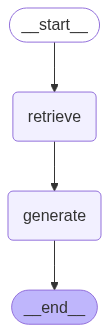

In [115]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [116]:
for step in graph.stream(
    {"question": "Which city introduced a congestion charge in early 2025?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='192c1e24-29d3-4894-927a-57752c2a8039', metadata={'source': 'https://en.wikipedia.org/wiki/2025_in_the_United_States', 'title': '2025 in the United States - Wikipedia', 'language': 'en', 'section': '1'}, page_content='2025 in the United States - Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJump to content\n\n\n\n\n\n\n\nMain menu\n\n\n\n\n\nMain menu\nmove to sidebar\nhide\n\n\n\n\t\tNavigation\n\t\n\n\nMain pageContentsCurrent eventsRandom articleAbout WikipediaContact us\n\n\n\n\n\n\t\tContribute\n\t\n\n\nHelpLearn to editCommunity portalRecent changesUpload fileSpecial pages\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAppearance\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nDonate\n\nCreate account\n\nLog in\n\n\n\n\n\n\n\n\nPersonal tools\n\n\n\n\n\nDonate Create account Log in\n\n\n\n\n\n\t\tPages for logged out editors learn more\n\n\n\nContributionsTalk\n\n\n

## Dialog flow

In [117]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [118]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [119]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = model.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = model.invoke(prompt)
    return {"messages": [response]}

In [120]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

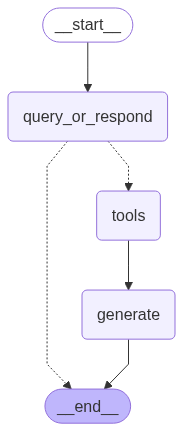

In [121]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Example without Memory

In [122]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [124]:
input_message = "How did the SpaceX Starship test flight end in 2025?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How did the SpaceX Starship test flight end in 2025?
================================== Ai Message ==================================
Tool Calls:
  retrieve (091d735d-cbc3-4429-8292-a1543ee2fce4)
 Call ID: 091d735d-cbc3-4429-8292-a1543ee2fce4
  Args:
    query: SpaceX Starship test flight in 2025
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://en.wikipedia.org/wiki/2025_in_the_United_States', 'title': '2025 in the United States - Wikipedia', 'language': 'en', 'section': '4'}
Content: CMA CGM announces a $20 billion investment in United States logistics over the next four years, aiming to create 10,000 new jobs.[292]
President Donald Trump signs an executive order creating a Strategic Bitcoin Reserve funded exclusively with bitcoin seized in criminal and civil forfeiture cases.[293]
According to a report in the academic journal Sc

In [125]:
input_message = "What did President Biden ban before leaving office?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What did President Biden ban before leaving office?
================================== Ai Message ==================================

Could you please provide more details or context? I don't have enough information to understand what you are asking. Which office are you referring to? Do you mean before President Biden left his previous office or before his term as President ends?


### Memory (to track context across messages)

In [126]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [127]:
input_message = "Who attended Trump’s 2025 inauguration?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Who attended Trump’s 2025 inauguration?
================================== Ai Message ==================================
Tool Calls:
  retrieve (bc74c23e-0511-4d68-9fa8-1650d3cb9445)
 Call ID: bc74c23e-0511-4d68-9fa8-1650d3cb9445
  Args:
    query: Who attended Trump’s 2025 inauguration?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://en.wikipedia.org/wiki/2025_in_the_United_States', 'title': '2025 in the United States - Wikipedia', 'language': 'en', 'section': '7'}
Content: ^ Balk, Tim (November 6, 2024). "When Will Donald Trump Take Office?". The New York Times. Retrieved November 6, 2024.

^ Reilly, Ryan J. (January 20, 2025). "Trump pardons roughly 1,500 criminal defendants charged in the Jan. 6 Capitol attack". NBC News. NBCUniversal Media, LLC. Retrieved January 20, 2025.

^ Daniels, Cheyanne M. (November 13, 2024). "Sharpt

In [128]:
input_message = "Which city implemented the first congestion charge in the U.S. in January 2025?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which city implemented the first congestion charge in the U.S. in January 2025?
================================== Ai Message ==================================
Tool Calls:
  retrieve (3587e354-2734-4051-a1bf-758d580bd716)
 Call ID: 3587e354-2734-4051-a1bf-758d580bd716
  Args:
    query: Which city implemented the first congestion charge in the U.S. in January 2025?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://en.wikipedia.org/wiki/2025_in_the_United_States', 'title': '2025 in the United States - Wikipedia', 'language': 'en', 'section': '1'}
Content: January 3
The 119th Congress begins. Vice President Kamala Harris officiates the swearing-in of senators, while representatives vote to re-elect Mike Johnson as speaker of the House.[11]
President Joe Biden blocks the proposed acquisition of U.S. Steel by Nippon Steel.[12]
Surgeon